# DAPT 612: Text Mining
## Assignment 1: Part 1
Brie Dubinsky, Group 3

Aaron Clark -- Differences in feedback between male/female students, specialty: Aaron

In [54]:
# tag: #AC1103

from collections import OrderedDict
import csv
from elasticsearch import helpers, Elasticsearch as es
import en_core_web_sm
#import gensim.downloader as gensim_api
#import gensim
# import langdetect
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk.corpus import stopwords
import numpy as np
import os
import pandas as pd
#from pprint import pprint
import re
import requests
#from sklearn import feature_extraction, manifold
import spacy
#from spacy.matcher import Matcher
import string
from textblob import TextBlob
import texthero as hero
# import textacy
# from textacy import preprocessing, extract
import seaborn as sns
#import wordcloud
#from wordcloud import STOPWORDS
nlp = en_core_web_sm.load()
#matcher = Matcher(nlp.vocab)

#nltk.download('punkt')

#nltk.download('averaged_perceptron_tagger')

In [59]:
#AC1103

# LOCAL_REPOSITORY_LOCATION = os.environ['LOCAL_REPOSITORY_LOCATION'] 

# os.chdir(os.path.join(LOCAL_REPOSITORY_LOCATION, '612_TextMining'))

print(os.getcwd())

# LOCAL_REPOSITORY_LOCATION

C:\Users\clark\Documents\LOCAL_REPOSITORY_LOCATION\612_TextMining


In [20]:
os.getcwd() #AC1103

'C:\\Users\\clark\\Documents\\LOCAL_REPOSITORY_LOCATION\\612_TextMining'

In [64]:
# read in the file #AC1103
df = pd.read_csv('eval_data_dapt.csv', encoding = 'utf-8', dtype = str)

In [65]:
df.head(3)

,eval_id,student_id,gender,course,preceptor,epa_number,rating_score,rating_label,comments
0,55339,855,M,Pediatrics,Attending,EPA 1,3,I had to prompt them from time to time,Work on your interview structure. Keep it cons...
1,55453,855,M,Pediatrics,Attending,EPA 6,3,I had to prompt them from time to time,Develop ED focused presentation skills by pres...
2,56658,855,M,Pediatrics,Attending,EPA 2,4,I needed to be available just in case,Watch as many physical exams as possible


In [66]:
# join display label (competency) to epa_number

dfc = pd.read_excel('competency_definitions.xlsx')

dfm = pd.merge(df, dfc, on = 'epa_number', how = 'left' )

df = dfm

In [93]:
# exploratory

df = dfm

m_cnt = df.gender[df.gender == 'M'].count()
f_cnt = df.gender[df.gender == 'F'].count()

print(m_cnt, f_cnt)



798 442


In [96]:
gdr = df.groupby('gender')
crse = df.groupby('course')
gdr_crse = df.groupby(['gender', 'course'])
# gdr_crse.get_group(('M','Surgery')).count()

In [120]:
gdr.size()
# crse.size()

gender
F    442
M    798
dtype: int64

In [119]:
gdr_crse.size()

gender  course                 
F       Ambulatory                  57
        Family Medicine             50
        Internal Medicine           92
        Neurology                   26
        Obstetrics & Gynecology     47
        Pediatrics                  49
        Psychiatry                  64
        Surgery                     57
M       Ambulatory                 119
        Family Medicine            127
        Internal Medicine          141
        Neurology                   50
        Obstetrics & Gynecology     50
        Pediatrics                  93
        Psychiatry                 140
        Surgery                     78
dtype: int64

# Description of the data set
This dataset represents a behavioral assessment of medical student clinical performance. Students receive these evaluations once a week from the supervising physicians who teach them. This assessment is similar to a workplace-based assessment (WBA) and provides students with a real-time understanding of their performance on 13 core clinical skills (<a href="https://www.aamc.org/what-we-do/mission-areas/medical-education/cbme/core-epas">entrustable professional activities</a>). The evaluation utilizes a modified version of the Ottawa Clinic Assessment Scale (<a href="https://pubmed.ncbi.nlm.nih.gov/27052202/">OCAT</a>) to describe the student's readiness for independent practice. In this dataset, the rating values range from 1 (_I had to do it for them_) to 5 (_I did not need to be there_).

## Manual pre-processing steps:

 - **Student:** I converted student names to lowercase.
 -  **Course:** I replaced a compound name (`Obstetrics & Gynecology`) with a short name (`Obstetrics`) to improve sorting/tagging.

In [26]:
data['student'] = data['student'].str.lower()

data['course'] = (data['course'].str.replace('Obstetrics & Gynecology', 'Obstetrics'))

KeyError: 'student'

In [ ]:
data['student'].unique()

array(['ryan', 'stephen', 'seth', 'matthew', 'mark', 'james', 'robert',
       'rebecca', 'scott', 'courtney', 'sarah', 'christopher', 'nicholas',
       'kelly', 'william', 'dennis', 'david', 'aaron', 'amanda',
       'katherine', 'eric', 'kimberly'], dtype=object)

I created a custom pipeline in TextHero that:

 - removes whitespace between words
 - removes common stopwords
 - removes punctuation, diacritics, and digits
 - drops empty rows

I will apply this later, after exploring the raw data further. 

In [ ]:
from texthero import preprocessing

custom_pipeline = [preprocessing.remove_whitespace,
                   preprocessing.remove_stopwords,
                   preprocessing.remove_diacritics,
                   preprocessing.remove_punctuation,
                   preprocessing.remove_digits,
                   preprocessing.drop_no_content]

There are eight core specialties represented in the dataset:

In [ ]:
data['course'].unique()

array(['Pediatrics', 'Obstetrics', 'Neurology', 'Psychiatry',
       'Ambulatory', 'Family Medicine', 'Surgery', 'Internal Medicine'],
      dtype=object)

Students receive instruction from supervising senior physicians (attendings), physicians pursuing specialized post-graduate training (residents), and various members of the healthcare team (e.g., nurses).

In [ ]:
data.preceptor.unique()

array(['Attending', 'Resident', 'Other'], dtype=object)

# Descriptive statistics

There are 1,240 observations in the dataset, representing evaluations on 22 students. It's interesting that the most frequent comment in the dataset is "no comments," because comments are recorded in a free-text field (i.e., there are no "canned" or pre-populated options). Given the busy pace of work in the hospital, and the high volume of required paperwork they must also complete, this is understandable though not ideal.

In [ ]:
data.describe()

,student,gender,course,preceptor,competency,rating,competency_label,comments_raw
count,1240,1240,1240,1240,1240,1240,1240,1240
unique,22,2,8,3,13,5,5,1120
top,james,M,Internal Medicine,Attending,EPA 1,4,I needed to be available just in case,No comments
freq,90,798,233,596,299,641,641,38


I was curious to see whether the ratings aligned with qualitative feedback, as most evaluations rate students at a 4 or higher. A small sample reveals some room for improvement and a few common typos. For example, one physician used the shorthand for "patient" ("pt") when perhaps they're referring to the student (Ryan). 

In [ ]:
data[data['rating'] == '5'].head()

,student,gender,course,preceptor,competency,rating,competency_label,comments_raw
12,ryan,M,Neurology,Attending,EPA 6,5,I did not need to be there,Pt would easily become independent with additi...
15,ryan,M,Psychiatry,Resident,EPA 2,5,I did not need to be there,Doing a good job
16,ryan,M,Psychiatry,Resident,EPA 2,5,I did not need to be there,Doing a good job
17,ryan,M,Psychiatry,Resident,EPA 7,5,I did not need to be there,continuing to do good work
19,ryan,M,Psychiatry,Resident,EPA 1,5,I did not need to be there,Very thorough. Doing a great job


## Checking for missing values

We don't have any missing values in this data set, which simplifies some steps for cleaning.

In [ ]:
data.isna().sum()

student             0
gender              0
course              0
preceptor           0
competency          0
rating              0
competency_label    0
comments_raw        0
dtype: int64

# Are students evaluated more often in some competencies than others?
There seems to be a preference for evaluating students in their history and physical exam (EPA 1), oral presentations (EPA 6), clinical documentation (EPA 5), and differential diagnosis (EPA 2). This makes sense, because many of the less utilized competencies represent complex tasks that students may not be authorized to perform in every setting.

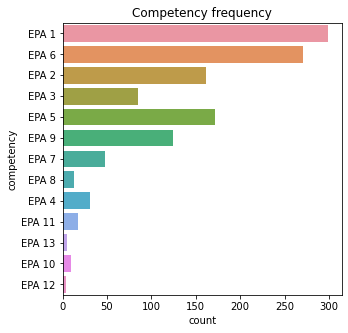

In [ ]:
total = len(data)

plt.figure(figsize = (5, 5))
plt.title('Competency frequency')
ax = sns.countplot(y = 'competency', data = data)
for p in ax.patches:
    percentage = '{0:.0f}%'.format(p.get_height() / total * 100)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 20
    ax.annotate(percentage, (x, y), ha = 'center')
plt.show()

# Visualize the comments in a word cloud

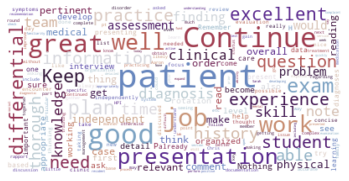

In [ ]:
# https://amueller.github.io/word_cloud/auto_examples/simple.html
# https://www.python-graph-gallery.com/wordcloud/
# https://towardsdatascience.com/how-to-create-beautiful-word-clouds-in-python-cfcf85141214

from nltk.corpus import stopwords
stopwords = nltk.corpus.stopwords.words('english')
from wordcloud import WordCloud, STOPWORDS

# collect the comments
comment = " ".join(comment for comment in data.comments_raw)
wordcloud = WordCloud(max_font_size = 40,
                      collocations = False, 
                      stopwords = stopwords,
                      margin = 0, 
                      background_color = 'white', 
                      colormap = 'twilight').generate(comment)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.savefig('wordcloud11.png')
plt.show()

Based on the information visualized in the wordcloud, I decided to incorporate key words, like "patient" and "student" into the list of stopwords.

In [ ]:
wn = nltk.WordNetLemmatizer()

# Create function for text cleaning 
def clean_text(text):
    text = ''.join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.findall('\S+', text)
    text = [wn.lemmatize(word) for word in tokens if word not in stopwords] 
    return text

data['words'] = data['comments_raw'].apply(lambda x: clean_text(str(x)))

# Define extra stopwords
extra_stopwords = ['history', 'h', 'p', 'sure', 'well', 'patient', 'student', 'exam', 'make']

# this doesn't seem to matter :/
names = list(data['student'].unique())
extra_stopwords.append(names)

# Remove extra stopwords  
data['words'] = data['words'].apply(lambda x: [word for word in x if word not in extra_stopwords])

In [ ]:
data[['comments_raw', 'words']].head(20)

,comments_raw,words
0,Work on your interview structure. Keep it cons...,"[work, interview, structure, keep, consistent,..."
1,Develop ED focused presentation skills by pres...,"[develop, ed, focused, presentation, skill, pr..."
2,Watch as many physical exams as possible,"[watch, many, physical, possible]"
3,Should work on being more methodical in collec...,"[work, methodical, collecting, information, pr..."
4,Did well reorganizing the assessment by proble...,"[reorganizing, assessment, problem, plan, prob..."
5,I think it's great to get involved with what p...,"[think, great, get, involved, physical, therap..."
6,"Present, scrubbed and engaged for a hysterecto...","[present, scrubbed, engaged, hysterectomy, ask..."
7,Needs to work on physical exam skills and orga...,"[need, work, physical, skill, organizing, pres..."
8,This was a presentation for a case based teach...,"[presentation, case, based, teaching, conferen..."
9,Doing just fine for a new third year.,"[fine, new, third, year]"


As I experimented with various NLP packages, I opted to preserve the "raw comments" and added a new column for comments I passed through the TextHero preprocessing pipleline.

In [ ]:
data['comments_clean'] = data['comments_raw']

# clean the comments but preserve the original comments
data['comments_clean'] = hero.clean(data['comments_clean'], custom_pipeline)

data.head(10)

,student,gender,course,preceptor,competency,rating,competency_label,comments_raw,words,comments_clean
0,ryan,M,Pediatrics,Attending,EPA 1,3,I had to prompt them from time to time,Work on your interview structure. Keep it cons...,"[work, interview, structure, keep, consistent,...",Work interview structure Keep consistent ...
1,ryan,M,Pediatrics,Attending,EPA 6,3,I had to prompt them from time to time,Develop ED focused presentation skills by pres...,"[develop, ed, focused, presentation, skill, pr...",Develop ED focused presentation skills presen...
2,ryan,M,Pediatrics,Attending,EPA 2,4,I needed to be available just in case,Watch as many physical exams as possible,"[watch, many, physical, possible]",Watch many physical exams possible
3,ryan,M,Pediatrics,Attending,EPA 3,3,I had to prompt them from time to time,Should work on being more methodical in collec...,"[work, methodical, collecting, information, pr...",Should work methodical collecting informat...
4,ryan,M,Pediatrics,Attending,EPA 5,3,I had to prompt them from time to time,Did well reorganizing the assessment by proble...,"[reorganizing, assessment, problem, plan, prob...",Did well reorganizing assessment problem p...
5,ryan,M,Pediatrics,Attending,EPA 9,4,I needed to be available just in case,I think it's great to get involved with what p...,"[think, great, get, involved, physical, therap...",I think great get involved physical thera...
6,ryan,M,Obstetrics,Attending,EPA 9,3,I had to prompt them from time to time,"Present, scrubbed and engaged for a hysterecto...","[present, scrubbed, engaged, hysterectomy, ask...",Present scrubbed engaged hysterectomy Ask...
7,ryan,M,Obstetrics,Resident,EPA 6,3,I had to prompt them from time to time,Needs to work on physical exam skills and orga...,"[need, work, physical, skill, organizing, pres...",Needs work physical exam skills organizing ...
8,ryan,M,Obstetrics,Attending,EPA 6,3,I had to prompt them from time to time,This was a presentation for a case based teach...,"[presentation, case, based, teaching, conferen...",This presentation case based teaching conf...
9,ryan,M,Obstetrics,Resident,EPA 7,3,I had to prompt them from time to time,Doing just fine for a new third year.,"[fine, new, third, year]",Doing fine new third year


# Visualizing top words associated with high/low evaluation ratings

Text(0.5, 1.0, 'Words used often in evaluations with high ratings')

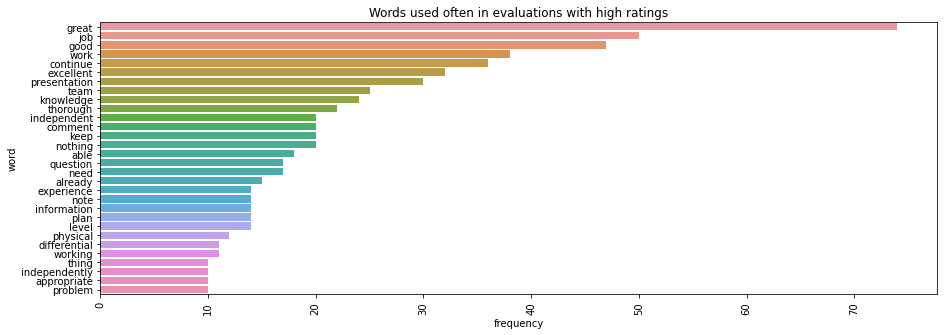

In [ ]:
from collections import Counter

high_rating = list(data.loc[data.rating == '5', 'words'])

# Flatten list of lists
high_rating = list(np.concatenate(high_rating).flat)

# Create dictionary to store word frequency
high_rating = Counter(high_rating)
hr_words = pd.DataFrame(high_rating.most_common(30), columns = ['word', 'frequency'])

# plot most common words related to the H&P competency
fig, ax = plt.subplots(figsize = (15, 5))
sns.barplot(x = 'frequency', y = 'word', data = hr_words, ax = ax)
plt.xticks(rotation = '90')
plt.title('Words used often in evaluations with high ratings')

The results make sense, given that lower ratings indicate that the student's skills are developing. Words like _continue_ and _practice_ reflect this.

Text(0.5, 1.0, 'Words used often in evaluations with low ratings')

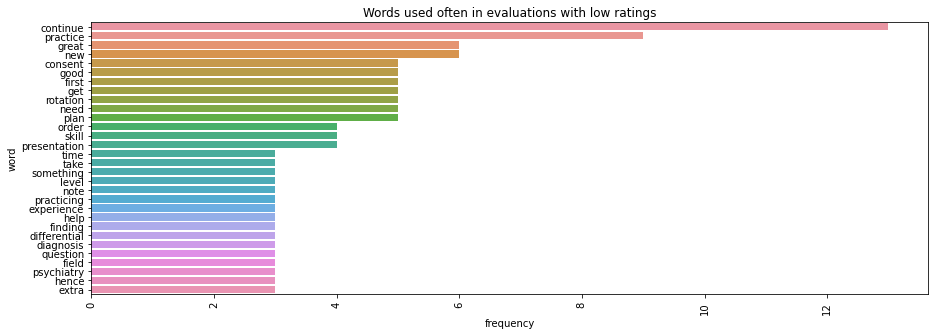

In [ ]:
low_rating = list(data.loc[data.rating < '3', 'words'])

# Flatten list of lists
low_rating = list(np.concatenate(low_rating).flat)

# Create dictionary to store word frequency
low_rating = Counter(low_rating)
lr_words = pd.DataFrame(low_rating.most_common(30), columns = ['word', 'frequency'])

# plot most common words related to the H&P competency
fig, ax = plt.subplots(figsize = (15, 5))
sns.barplot(x = 'frequency', y = 'word', data = lr_words, ax = ax)
plt.xticks(rotation = '90')
plt.title('Words used often in evaluations with low ratings')

# SQL Lite

As I was exploring different techniques, I came across a suggestion to utilize SQL Lite (<a href="https://www.oreilly.com/library/view/blueprints-for-text/9781492074076/ch04.html">Albrecht, Ramachanran, & Winkler</a>). I kept this in my final list of steps because it provided additional flexibility to revert back to earlier iterations of the dataframe.

In [ ]:
data.columns

Index(['student', 'gender', 'course', 'preceptor', 'competency', 'rating',
       'competency_label', 'comments_raw', 'words', 'comments_clean'],
      dtype='object')

In [ ]:
column_map = {'course' : 'course', 'student' : 'student', 'gender' : 'gender', 'competency' : 'competency', 
              'competency_label' : 'competency_label', 'rating' : 'rating', 'comments_raw': 'comments_raw'
              }

# define remaining columns
columns = [c for c in column_map.keys() if column_map[c] != None]

# select and rename those columns
eval_data = data[columns].rename(columns = column_map)

In [ ]:
eval_data.head(3)

,course,student,gender,competency,competency_label,rating,comments_raw
0,Pediatrics,ryan,M,EPA 1,I had to prompt them from time to time,3,Work on your interview structure. Keep it cons...
1,Pediatrics,ryan,M,EPA 6,I had to prompt them from time to time,3,Develop ED focused presentation skills by pres...
2,Pediatrics,ryan,M,EPA 2,I needed to be available just in case,4,Watch as many physical exams as possible


In [ ]:
import sqlite3
# https://www.oreilly.com/library/view/blueprints-for-text/9781492074076/ch04.html

db_name = 'evaluation.db'
con = sqlite3.connect(db_name)
eval_data.to_sql('eval', con, 
            index = False, 
            if_exists = 'replace')
con.close()

In [ ]:
con = sqlite3.connect(db_name)
sample_evals = pd.read_sql("select competency_label, rating, comments_raw from eval", con)
con.close()

# Sentiment analysis

I used Spacy, Textacy, and TextBlob for sentiment analysis and named entity recognition (NER).

In [123]:
texts = data['comments_raw'].str.split('\n')

string = ' '.join([str(item) for item in texts])

blob = TextBlob(string)

doc = nlp(string)

KeyError: 'comments_raw'

In [122]:
from textacy.extract import keyterms as kt

# get key terms
kt.textrank(doc, normalize = "lemma", topn = 10)

ModuleNotFoundError: No module named 'textacy'

I extracted the polarity of statements in the dataset, using a random sample.

In [ ]:
# https://towardsdatascience.com/having-fun-with-textblob-7e9eed783d3f

sample = sample_evals.sample(frac = 0.8, replace = False, random_state = 1)

def detect_polarity(text):
    return TextBlob(text).sentiment.polarity

sample['polarity'] = sample.comments_raw.apply(detect_polarity)

In [ ]:
sample.head(10)

,competency_label,rating,comments_raw,polarity
119,I had to prompt them from time to time,3,doing well,0.000000
202,I needed to be available just in case,4,Experience with time,0.000000
482,I needed to be available just in case,4,Continue seeing patients and developing differ...,0.000000
403,I had to prompt them from time to time,3,Continue to familiarize yourself with DSM5 cri...,-0.118750
259,I did not need to be there,5,No comments,0.000000
167,I did not need to be there,5,Good recognition of MSK and good DPX,0.700000
940,I needed to be available just in case,4,Great at obtaining relevant information. Just ...,0.225455
679,I needed to be available just in case,4,Continue to practice.,0.000000
1076,I did not need to be there,5,Excellent documentation of your call with her ...,0.300000
991,I needed to be available just in case,4,Did well on a fairly complicated patient.,-0.500000


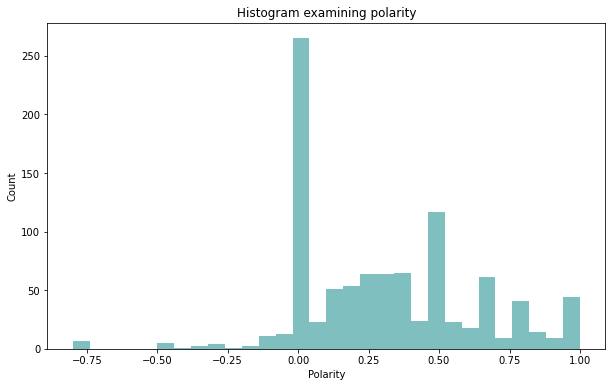

In [ ]:
num_bins = 30
plt.figure(figsize = (10,6))
n, bins, patches = plt.hist(sample.polarity, num_bins, facecolor = 'teal', alpha = 0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Histogram examining polarity')
plt.show();

It seems to be correctly flagging words like "excellent", and it's interesting to see that these are associated with the highest possible rating (_I did not need to be there_).

In [ ]:
sample[sample.polarity > .30].head(5)

,competency_label,rating,comments_raw,polarity
167,I did not need to be there,5,Good recognition of MSK and good DPX,0.700000
1076,I did not need to be there,5,Excellent documentation of your call with her ...,0.300000
65,I did not need to be there,5,good job on this task,0.700000
831,I had to prompt them from time to time,3,Continue to synthesize patient information as ...,0.366667
815,I did not need to be there,5,Jim creates excellent differentials and is a v...,0.760000


Neutral statements are more mixed in quality--again, _no comments_ surfaces. It's not surprising to see that ratings skew a little high, in general.

In [ ]:
sample[sample.polarity == 0].head(5)

,competency_label,rating,comments_raw,polarity
119,I had to prompt them from time to time,3,doing well,0.0
202,I needed to be available just in case,4,Experience with time,0.0
482,I needed to be available just in case,4,Continue seeing patients and developing differ...,0.0
259,I did not need to be there,5,No comments,0.0
679,I needed to be available just in case,4,Continue to practice.,0.0


In [ ]:
sample[sample.polarity < 0].head(5)

,competency_label,rating,comments_raw,polarity
403,I had to prompt them from time to time,3,Continue to familiarize yourself with DSM5 cri...,-0.11875
991,I needed to be available just in case,4,Did well on a fairly complicated patient.,-0.50000
575,I needed to be available just in case,4,"at expected level, just continue to read and s...",-0.10000
1196,I needed to be available just in case,4,Very clear presentation on an evasive patient....,-0.04250
777,I had to prompt them from time to time,3,when there is a missing piece of information o...,-0.10000


In [ ]:
# https://stackoverflow.com/questions/67983109/how-can-i-pass-table-or-dataframe-instead-of-text-with-entity-recognition-using
def get_entities(x):
    result = {}
    doc = nlp(x)
    for ent in doc.ents:
        result[ent.label_] = ent.text
    return result

ent_matches = data['comments_raw'].apply(get_entities)

ent_matches

0                                          {}
1                       {'ORG': 'Develop ED'}
2                                          {}
3       {'DATE': 'just beginning third year'}
4                                          {}
                        ...                  
1235                        {'DATE': 'daily'}
1236                   {'PERSON': 'Kimberly'}
1237                                       {}
1238                                       {}
1239                                       {}
Name: comments_raw, Length: 1240, dtype: object

In [ ]:
sample.describe()

,polarity
count,992.000000
mean,0.306842
std,0.325759
min,-0.800000
25%,0.000000
50%,0.275000
75%,0.500000
max,1.000000


I used a few sample phrases to train a small model for sentiment analysis.

In [ ]:
from textblob import classifiers

training = [
    ('great job especially beginning third year', 'pos'), 
    ('wonderful building rapport', 'pos'),
    ('handled communication non English speaking family well', 'pos'),
    ('integrates strong organization skills complex scenario', 'pos'),
    ('thorough physical exam Well done', 'pos'),
    ('Great job', 'pos'),
    ('Good job. Continue good work', 'pos'),
    ('Great work, especially early in third year!' , 'pos'),
    ('Presentations could concise organized No need repeat studies imaging already discussed prior days', 'neg'),
    ('Should work on being more methodical in collecting information and presenting so nothing is forgotten or missed.', 'neg'),
    ('Work overall organization material want cover slow slightly allow audience follow discussion readily.', 'neg'),
    ('Great thoughts presented', 'pos'),
    ('Good critical thinking differential diagnosis presentation', 'pos'),
    ('More work needed. Continue reading and practicing.', 'neg'),
    ('Continue work on your knowledge base.', 'neg'),
    ('Asked appropriate questions, but would encourage him to closely observe more and ask only a few key, critical questions especially during surgery when the surgeons may be concentrating.', 'neg'), 
    ('Keep it consistent so you don’t forget things.', 'neg'), 
    ('the plan probably couldve been more streamlined by cutting out the old stuff', 'neg'), 
    ('Increase efficiency patient using interpreter requires intentional  rushed interaction.', 'neg'),
    ('Watch as many physical exams as possible.', 'neg'), 
    ('No comment.', 'neg'),
    ('needs continue work redirecting patient finishing interview timely manner. This comes with practice.', 'neg')]

classifier = classifiers.NaiveBayesClassifier(training)


Then, performing a quick test to see if the model can correctly flag the statement below as positive.

In [ ]:
classifier.classify('Wonderful student. Fantastic work!')

'pos'

Reviewing the output, it does a pretty good job, but providing it with richer training data may improve future results.

In [ ]:
# https://textblob.readthedocs.io/en/dev/classifiers.html
from textblob import Blobber
from textblob.taggers import NLTKTagger
from textblob.tokenizers import SentenceTokenizer

testing = data['comments_raw'].str.split('\n')

test_data = ' '.join([str(item) for item in testing])

tb = Blobber(pos_tagger = NLTKTagger(), tokenizer = SentenceTokenizer(), classifier = classifier)

blob = tb(test_data)

for s in blob.sentences:
    print(s)
    print(s.classify())

In [ ]:
classifier.show_informative_features(5)

Most Informative Features
    contains(especially) = True              pos : neg    =      2.0 : 1.0
          contains(work) = True              neg : pos    =      1.5 : 1.0
      contains(Continue) = True              neg : pos    =      1.4 : 1.0
         contains(Great) = False             neg : pos    =      1.4 : 1.0
           contains(job) = False             neg : pos    =      1.4 : 1.0


# PCA with TextHero

In [121]:
import texthero as hero
import pandas as pd

df['tfidf'] = (
    data['comments_raw']
    .pipe(hero.clean)
    .pipe(hero.tfidf)
)

df['kmeans_labels'] = (
    df['tfidf']
    .pipe(hero.kmeans, n_clusters = 5)
    .astype(str)
)

df['pca'] = df['tfidf'].pipe(hero.pca)

hero.scatterplot(df, 'pca', color = 'kmeans_labels', title = 'K-means')

KeyError: 'comments_raw'

# Entity recognition in Spacy

This aspect of the project took a few iterations. I noticed that Spacy would correctly identify one, or sometimes a few instances of a name (e.g., _Amanda_, but wouldn't flag every instance. There were some misclassifications, like _H&P_ (medical shorthand for "history and physical"), which Spacy identified as an organization.

In the future, I plan to further refine the pre-processing options to replace common medical shorthand with full words. Additionally, I'd like to explore the Spacy library to customize and improve on the model's ability to recognize entities in the data. 

In [ ]:
from spacy import displacy

nlp = spacy.load('en_core_web_trf')

spacy.displacy.render(doc, style = 'ent')

In [ ]:
# predicting named entities
for ent in doc.ents:
    print(ent.text, ent.label_)

In [ ]:
list(extract.keyword_in_context(doc, 'good', window_width = 25, pad_context = True))

In [ ]:
nlp.analyze_pipes()

In [ ]:
from elasticsearch import helpers, Elasticsearch
import csv

es = Elasticsearch()

In [ ]:
with open('sample_xport.csv', encoding="utf-8") as f:
    reader = csv.DictReader(f)
    helpers.bulk(es, reader, index='epa')

C:\Users\short\anaconda3\lib\site-packages\elasticsearch\connection\base.py:208: ElasticsearchWarning:

Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.14/security-minimal-setup.html to enable security.

